# Module II - Assignment 1

You can complete this by yourself or with 1-2 other people. List all names at the top of the module when you submit.

The initial data for this assignment came from UCI's Machine Learning Repository, though has been modified and loosely framed around a client inquiry that LionBase processed in the past.

## Problem

EnviroBox is a company in North Africa that has developed a modular and affordable greenhouse for farmers hit hard by climate change. Their business model works as follows:
- Provide loans to farmers to finance the greenhouse
- The farmer eventually pays back EnviroBox with interest through the crop earnings

If an individual receives a loan and ends being unable to pay it back, EnviroBox loses \$5,000 on average.

If an individual receives a loan and ends up being able to pay it back, EnviroBox earns \$5,000 on average.

EnviroBox would like to engage in a marketing campaign to get people to take their loans. The goal is to predict whether or not someone will take the farm loan.

enviro-box.csv contains the following data fields:
- age
- job
- marital 
- education
- default (has credit in default?)
- balance (amount of money they currently have)
- housing (whether they currently have a housing loan in the past)
- personal_loan (whether they currently have an existing personal loan not from EnviroBox)
- contact (how they were contacted)
- day (day of the week, in numbers)
- month
- duration (last contact duration, in seconds)
- campaign (# of contacts performed during this campaign and for this client)
- pdays (# of days that passed by after client was last contacted from previous campaign)
- poutcome (outcome of previous marketing campaign)
- y (whether or not the client has taken a loan from EnviroBox) -- **this is the dependent variable we are predicting**

Use this data to create a model for predicting whether or not someone takes a farm loan from EnviroBox.

For this assignment:
- Create at least 3 different supervised models for predicting whether or not someone takes a farm loan from EnviroBox
- Out of the models created, select one model to recommend to EnviroBox and provide justification for the recommendation

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import time
%matplotlib inline





df =  pd.read_csv("enviro-box.csv", index_col = 0)

In [2]:
df.head()

,age,job,marital,education,default,balance,housing,personal_loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,rancher,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,largeholder farmer,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,smallholder farmer,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [38]:
y = df[df.columns[16]].values
y #independent variable 

array(['no', 'no', 'no', ..., 'yes', 'no', 'no'], dtype=object)

In [39]:
encoder = LabelEncoder() 
encoder.fit(y)
y = encoder.transform(y) # labels Y and N classes numerically 
y

array([0, 0, 0, ..., 1, 0, 0])

Now I want to find out information on some of the categorical data

In [6]:
df['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [7]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [8]:
df['job'].value_counts()

smallholder farmer    11311
management             9458
rancher                7597
largeholder farmer     6658
mixed farmer           4154
retired                2264
unemployed             1303
subsistence farmer     1240
student                 938
unknown                 288
Name: job, dtype: int64

In [9]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

Because the outcome of such a significant number of previous campaigning is unknown, I will not include this feature in my model.

In [10]:
selected_columns = ['age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 
       'personal_loan', 'contact', 'month', 'duration', 'campaign']
df = df[selected_columns]

I have choose to leave out pdays, poutcome and previous because poutcome is so overwhelmingly unknown it is hard to
use previous data with no outcome being known.  I left out days because month captures data that the day does  


In [11]:
df.shape

(45211, 12)

In [12]:
X = df
X = pd.get_dummies(X) # one hot encodes categorical variables

In [13]:
X.shape

(45211, 42)

In [14]:
X.head()

,age,balance,duration,campaign,job_largeholder farmer,job_management,job_mixed farmer,job_rancher,job_retired,job_smallholder farmer,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,2143,261,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,44,29,151,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,33,2,76,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,47,1506,92,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,33,1,198,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
model = linear_model.LinearRegression() # create linear regression model
model.fit(X_train,y_train) # fit results onto linear regression


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
y_pred  = model.predict(X_test) # get predictions on test data
y_pred # see what predictions look like

array([-0.01137897,  0.07344798,  0.42022784, ...,  0.1980389 ,
        0.45399393, -0.04359272])

In [17]:
def get_classification(predictions,threshold): # converts predictions into class predictions
    classes = np.zeros_like(predictions) # create array of zeros with same dimensions as predictions 
    for i in range(len(classes)): 
    # for each element in classes, convert to a 1 if the prediction is greater than the threshold
        if predictions[i] > threshold:
            classes[i] = 1
    return classes


In [18]:
get_classification(y_pred,0.5)

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
acc = accuracy_score(y_true=y_test, y_pred=get_classification(y_pred,0.5)) # get accuracy
acc

0.8931257188357073

Accuracy is really good to start off using normal linear regression.  Now I will check some other tests to see 
if accuracy can get better.  Then I will adjust my threshold accordingly to help the company make as much money
as they can.

First I will check the Random forest Case


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
for d in range(10): # compare performance as depth of random forest increases
    print('**********')
    start_time = time.time() # get start time
    print('Depth: {}'.format(d+1))
    clf = RandomForestClassifier(max_depth=d+1, random_state=0)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    acc = accuracy_score(y_true=y_test, y_pred=predicted)
    print('Accuracy: {}'.format(acc))
    print('Runtime: {} seconds'.format(time.time() - start_time)) # calculate run time

**********
Depth: 1
Accuracy: 0.8802972662125099
Runtime: 0.7023251056671143 seconds
**********
Depth: 2
Accuracy: 0.8802972662125099
Runtime: 1.1108534336090088 seconds
**********
Depth: 3
Accuracy: 0.8802972662125099
Runtime: 1.291226863861084 seconds
**********
Depth: 4
Accuracy: 0.8802972662125099
Runtime: 1.3983657360076904 seconds
**********
Depth: 5
Accuracy: 0.8802972662125099
Runtime: 1.4626789093017578 seconds
**********
Depth: 6
Accuracy: 0.8802972662125099
Runtime: 1.7369024753570557 seconds
**********
Depth: 7
Accuracy: 0.8809165708219057
Runtime: 2.018526315689087 seconds
**********
Depth: 8
Accuracy: 0.8814474033442449
Runtime: 2.127593994140625 seconds
**********
Depth: 9
Accuracy: 0.8821551800406972
Runtime: 2.219744920730591 seconds
**********
Depth: 10
Accuracy: 0.8847208705653367
Runtime: 2.527189254760742 seconds


In [27]:
y

array([0, 0, 0, ..., 1, 0, 0])

In [30]:
y.sum()

5289

Just thought to check the percentage of people who took loans and its around 11%, so 1 - .11 = .89.  So denying 90% of the time would be a accurate estimator.


The random forest does not get better with depth at all, but is under linear regression.  I am curious to see what features where most impostant in this trial though

In [31]:
clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(X_train, y_train)
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False) 

top_ten = feature_importances.head(10) # show top 10 features
top_ten

,importance
duration,0.486145
age,0.086503
contact_unknown,0.052276
month_oct,0.043769
housing_no,0.038753
month_sep,0.036760
month_mar,0.036535
housing_yes,0.031752
contact_cellular,0.031742
balance,0.024927


This is interesting, duration I would have figured would be important because people who are interested would be on the phone longer naturally,
I thought age might play a factor too, but I would have thought balance would be much higher.  The fact month has something to do with it 
in this model is interesting too.

Next, logit regression because we are producing yes or no as an output

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict_proba(X_test)[:,1] # to get probabilities of y = 1
acc = accuracy_score(y_true=y_test, y_pred=get_classification(y_pred,0.5))
acc

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8864018402194108

Still not better than linear regression, Now that best performance is settled, I want to play around with the threshold to best make the company money

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
model = linear_model.LinearRegression() # create linear regression model
model.fit(X_train,y_train) # fit results onto linear regression

y_pred  = model.predict(X_test) # get predictions on test data

get_classification(y_pred,0.5)

acc = accuracy_score(y_true=y_test, y_pred=get_classification(y_pred,0.5)) # get accuracy
acc


0.8931257188357073

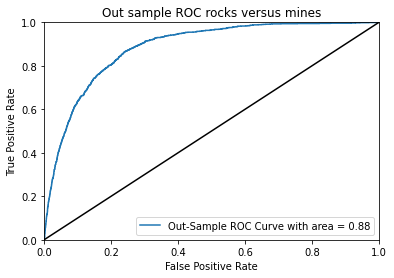

In [45]:
(fpr, tpr, thresholds) = roc_curve(y_test,y_pred)

area = auc(fpr,tpr) # get area under curve
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area) # plot ROC curve

plt.plot([0, 1], [0, 1], 'k') # plot line with slope 1
plt.xlim([0.0, 1.0]) # limit of x value
plt.ylim([0.0, 1.0]) # limit of y value
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC rocks versus mines')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.48')

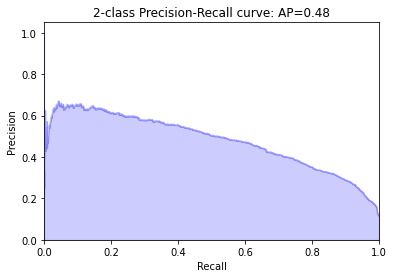

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred) # get precision and recall curve values
average_precision = average_precision_score(y_test, y_pred) # get avg precision

step_kwargs = ({'step' : 'post'}) # step function kew arguments

plt.step(recall, precision, color='b', alpha=0.2,
         where='post') 
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs) # create step plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ROC curve area is close to 1 so that is good, but the precision recall curve isnt that good.  But these classes are imbalanced so P-R curve is a better determinant

In [60]:
df =  pd.read_csv("enviro-box.csv", index_col = 0)

y = df[df.columns[16]].values
y #independent variable 

encoder = LabelEncoder() 
encoder.fit(y)
y = encoder.transform(y) # labels Y and N classes numerically 
y

selected_columns = ['age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 
       'personal_loan', 'contact', 'month', 'duration', 'campaign']
df = df[selected_columns]


X = df
X = pd.get_dummies(X) # one hot encodes categorical variables


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
model = linear_model.LinearRegression() # create linear regression model
model.fit(X_train,y_train) # fit results onto linear regression

y_pred  = model.predict(X_test) # get predictions on test data


def get_classification(predictions,threshold): # converts predictions into class predictions
    classes = np.zeros_like(y_pred) # create array of zeros with same dimensions as predictions 
    for i in range(len(classes)): 
    # for each element in classes, convert to a 1 if the prediction is greater than the threshold
        if predictions[i] > threshold:
            classes[i] = 1
    return classes


acc = accuracy_score(y_true=y_test, y_pred=get_classification(y_pred,0.5)) # get accuracy


thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # different thresholds for tau

best_t = 0
best_cost = -100000000 # arbitrarily large number
for t in thresholds:
    tn, fp, fn, tp = confusion_matrix(y_test,get_classification(y_pred,t)).ravel() # get confusion matrix values
    cost = (5000 * tp) - (5000 * fp) # calculate cost
    print('*****')
    print('Threshold: {}'.format(t))
    print('Cost: {}'.format(cost))
    if cost > best_cost: # update best cost
        best_cost = cost
        best_t = t

print('\n\nSUMMARY')
print('Best threshold: {}'.format(best_t))
print('Best cost: {}'.format(best_cost))
print('Accurate {}% of the time'.format(acc))



*****
Threshold: 0.1
Cost: -11995000
*****
Threshold: 0.2
Cost: -2355000
*****
Threshold: 0.3
Cost: 45000
*****
Threshold: 0.4
Cost: 565000
*****
Threshold: 0.5
Cost: 485000
*****
Threshold: 0.6
Cost: 260000
*****
Threshold: 0.7
Cost: 140000
*****
Threshold: 0.8
Cost: 20000
*****
Threshold: 0.9
Cost: 0


SUMMARY
Best threshold: 0.4
Best cost: 565000
Accurate 0.8931257188357073% of the time
